## Robinson Crusoe economy with more people and trade

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
from scipy.optimize import minimize, minimize_scalar
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import *

## Robinson Crusoe Economy Model

We consider a simplified economy consisting of only one inhabitant, Robinson Crusoe, living in a world where only two goods exist: $x_1$ and $x_2$.

#### Utility Function

Robinson derives utility from these goods through the following Cobb-Douglas utility function:

$$
U(x_1, x_2) = x_1^\alpha x_2^{1-\alpha}
$$

where $0 < \alpha < 1$. This parameter, $\alpha$, represents Robinson's relative preference for $x_1$ over $x_2$, highlighting the substitutability and relative importance of each good in satisfying his utility.

#### Production Function

Robinson can produce $x_2$ by converting $x_1$ through a production process described by:

$$
f(z) = z^\beta
$$

where $z$ represents the quantity of $x_1$ allocated to the production of $x_2$, and $0 < \beta < 1$ indicates diminishing returns to scale in the production of $x_2$. This production function encapsulates the physical transformation of $x_1$ into $x_2$ with efficiency determined by $\beta$.

### Model Solution

To solve this model, we aim to find an optimal allocation of goods $(x_1, x_2)$ such that no other feasible allocation yields higher utility for Robinson. The constraints of the model are defined by Robinson’s total endowments and his production capabilities, which can be expressed as:

$$
x_1 = e_1 - z
$$

$$
x_2 = e_2 + f(z)
$$

Here, \(e_1\) and \(e_2\) are Robinson's initial endowments of goods \(x_1\) and \(x_2\) respectively. The goal is to determine the value of \(z\) that maximizes Robinson's utility given his initial endowments and the production technology available to him, hence solving the following maximization problem:

$$
\max_{x_1,x_2}{u(x_1,x_2)} \space \space u.c. \space \space x_1 = e_1 - z, \space \space x_2 = e_2 + f(z)
$$

As preferences are assumed to be convex and production is concave, the problem can be solved by

$$
MRS = TRS
$$

For $0<\beta<1$, there is no algebraic solution for this problem, hence we proceed to a numerical approach in the following


## Numerical solution

We start out by solving the simple model generating random endowments, preference and production efficiency.

In [2]:
# Set seed (feel free to put your own)
np.random.seed(0)

# Generating parameters
alpha = np.random.random()
beta = np.random.random()
e1 = np.random.random()
e2 = np.random.random()

# Utility function
def u(x1, x2, alpha):
    return x1**alpha * x2**(1-alpha)

# Production function
def f(z, beta):
    return z**beta

# Function to minimize (-utility)
def objective_no_trade(x1, alpha, beta, e1, e2):
    z = e1 - x1
    x2 = e2 + f(z, beta)
    return -u(x1, x2, alpha)

# x1 must be between 0 and e1
bounds = (0, e1)

# Perform the minimization
result = minimize_scalar(objective_no_trade, bounds=bounds, method='bounded', args=(alpha, beta, e1, e2))

# Maximizing values
x1_max = result.x
z_max = e1 - x1_max
x2_max = e2 + f(z_max, beta)
u_max = u(x1_max, x2_max, alpha)

print(f"Robinson Crusoe: Optimal x1: {x1_max:.2f}, Optimal x2: {x2_max:.2f}, Optimal u: {u_max:.2f} ")

Robinson Crusoe: Optimal x1: 0.54, Optimal x2: 0.69, Optimal u: 0.60 


What if Robinson had some friends on the island?

Next we proceed by adding more people to the economy. We assume that all inhabitants have similar utility and production functions, but their preferences ($\alpha$), efficiency ($\beta$), and endowments vary. Hence, we generate a random $\alpha$, $\beta$, $e_1$ and $e_2$ for each inhabitant.

In [3]:
# Number of people
N = 50

# Set seed (feel free to put your own)
np.random.seed(4444)

# Parameters
alpha = np.random.uniform(low=0.1,high=0.9,size=N)
beta = np.random.uniform(low=0.1,high=0.9,size=N)
e1 =np.random.uniform(low=0,high=1,size=N)
e2 =np.random.uniform(low=0,high=1,size=N)

We start out by deriving each habitant's initial utility based on endowments

In [4]:
u_initial = []

for i in range(N):
    u_initial.append(u(e1[i],e2[i],alpha[i]))

Next, we allow people in the economy to trade. We find Wallrasian equilibrium and derive each habitant's utility.

In [5]:
p=1
#define function for excess demand
def excessdemand_fun(e1,e2,p,alpha):
    x1 = []
    for i in range(N):
        I = e1[i]*p + e2[i]
        x1.append(demand1(alpha[i],I,p))
    return abs(excessdemand1(e1,x1))

#optimize
bounds=[(1e-9,np.inf)]
result = minimize(lambda p: excessdemand_fun(e1,e2,p,alpha),p,
                  method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
p1_fin = result.x[0]

#find utility
u_trade = []
for i in range(N):
    I = e1[i]*p1_fin + e2[i]
    x1 = demand1(alpha[i],I,p1_fin)
    x2 = demand2(alpha[i],I)
    u_trade.append(u(x1,x2,alpha[i]))

Next, we no longer allow people to trade, but instead allow them to produce.

In [6]:
u_robinson = []
z = 0

for i in range(N):
    bounds = [(0,e1[i])]
    result = minimize(lambda z: -u_koop(e1[i],e2[i],z,alpha[i],beta[i]),z,
                      method="SLSQP",bounds=bounds,options={'ftol': 1e-9})
    u_robinson.append(-result.fun)

Finally, we also allow for people to produce and derive habitant's utility in Wallrasian equilibrium

In [7]:
#defining nested optimizer for utility in Robinson Crusoe with trade
def clear(alpha,beta,e1,e2,p1):
   
    #Maximizing income
    s=0
    I = []
    s_ = []

    for i in range(N):
        bounds=[(0,e1[i])]
        result = minimize(lambda s: -income(s,p1,e1[i],e2[i],beta[i]),s
                          ,method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
        I.append(-result.fun)
        s_.append(result.x[0])

    #Demand
    x1 = []
    x2 = []
    for i in range(N):
        x1.append(demand1(alpha[i],I[i],p1))
        x2.append(demand2(alpha[i],I[i]))

    #Excess demand
    return abs(excessdemand1(e1,x1))

In [8]:
#run optimization
p1=1
result = minimize(lambda p1: clear(alpha,beta,e1,e2,p1),p1,
                  method="SLSQP",bounds=[(1e-9,np.inf)])
p1_fin = result.x[0]


#find utility using optimal price
s=0
I = []
for i in range(N):
    bounds=[(0,e1[i])]
    result = minimize(lambda s: -income(s,p1_fin,e1[i],e2[i],beta[i]),s,
                      method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
    I.append(-result.fun)

u_all = []
for i in range(N):
    x1 = demand1(alpha[i],I[i],p1_fin)
    x2 = demand2(alpha[i],I[i])
    u_all.append(u(x1,x2,alpha[i]))

Now, let's take a look at the distribution of utility in each of the four versions of the economy. Recall that initial endowments, productivity, and preferences are the same for each person across models.

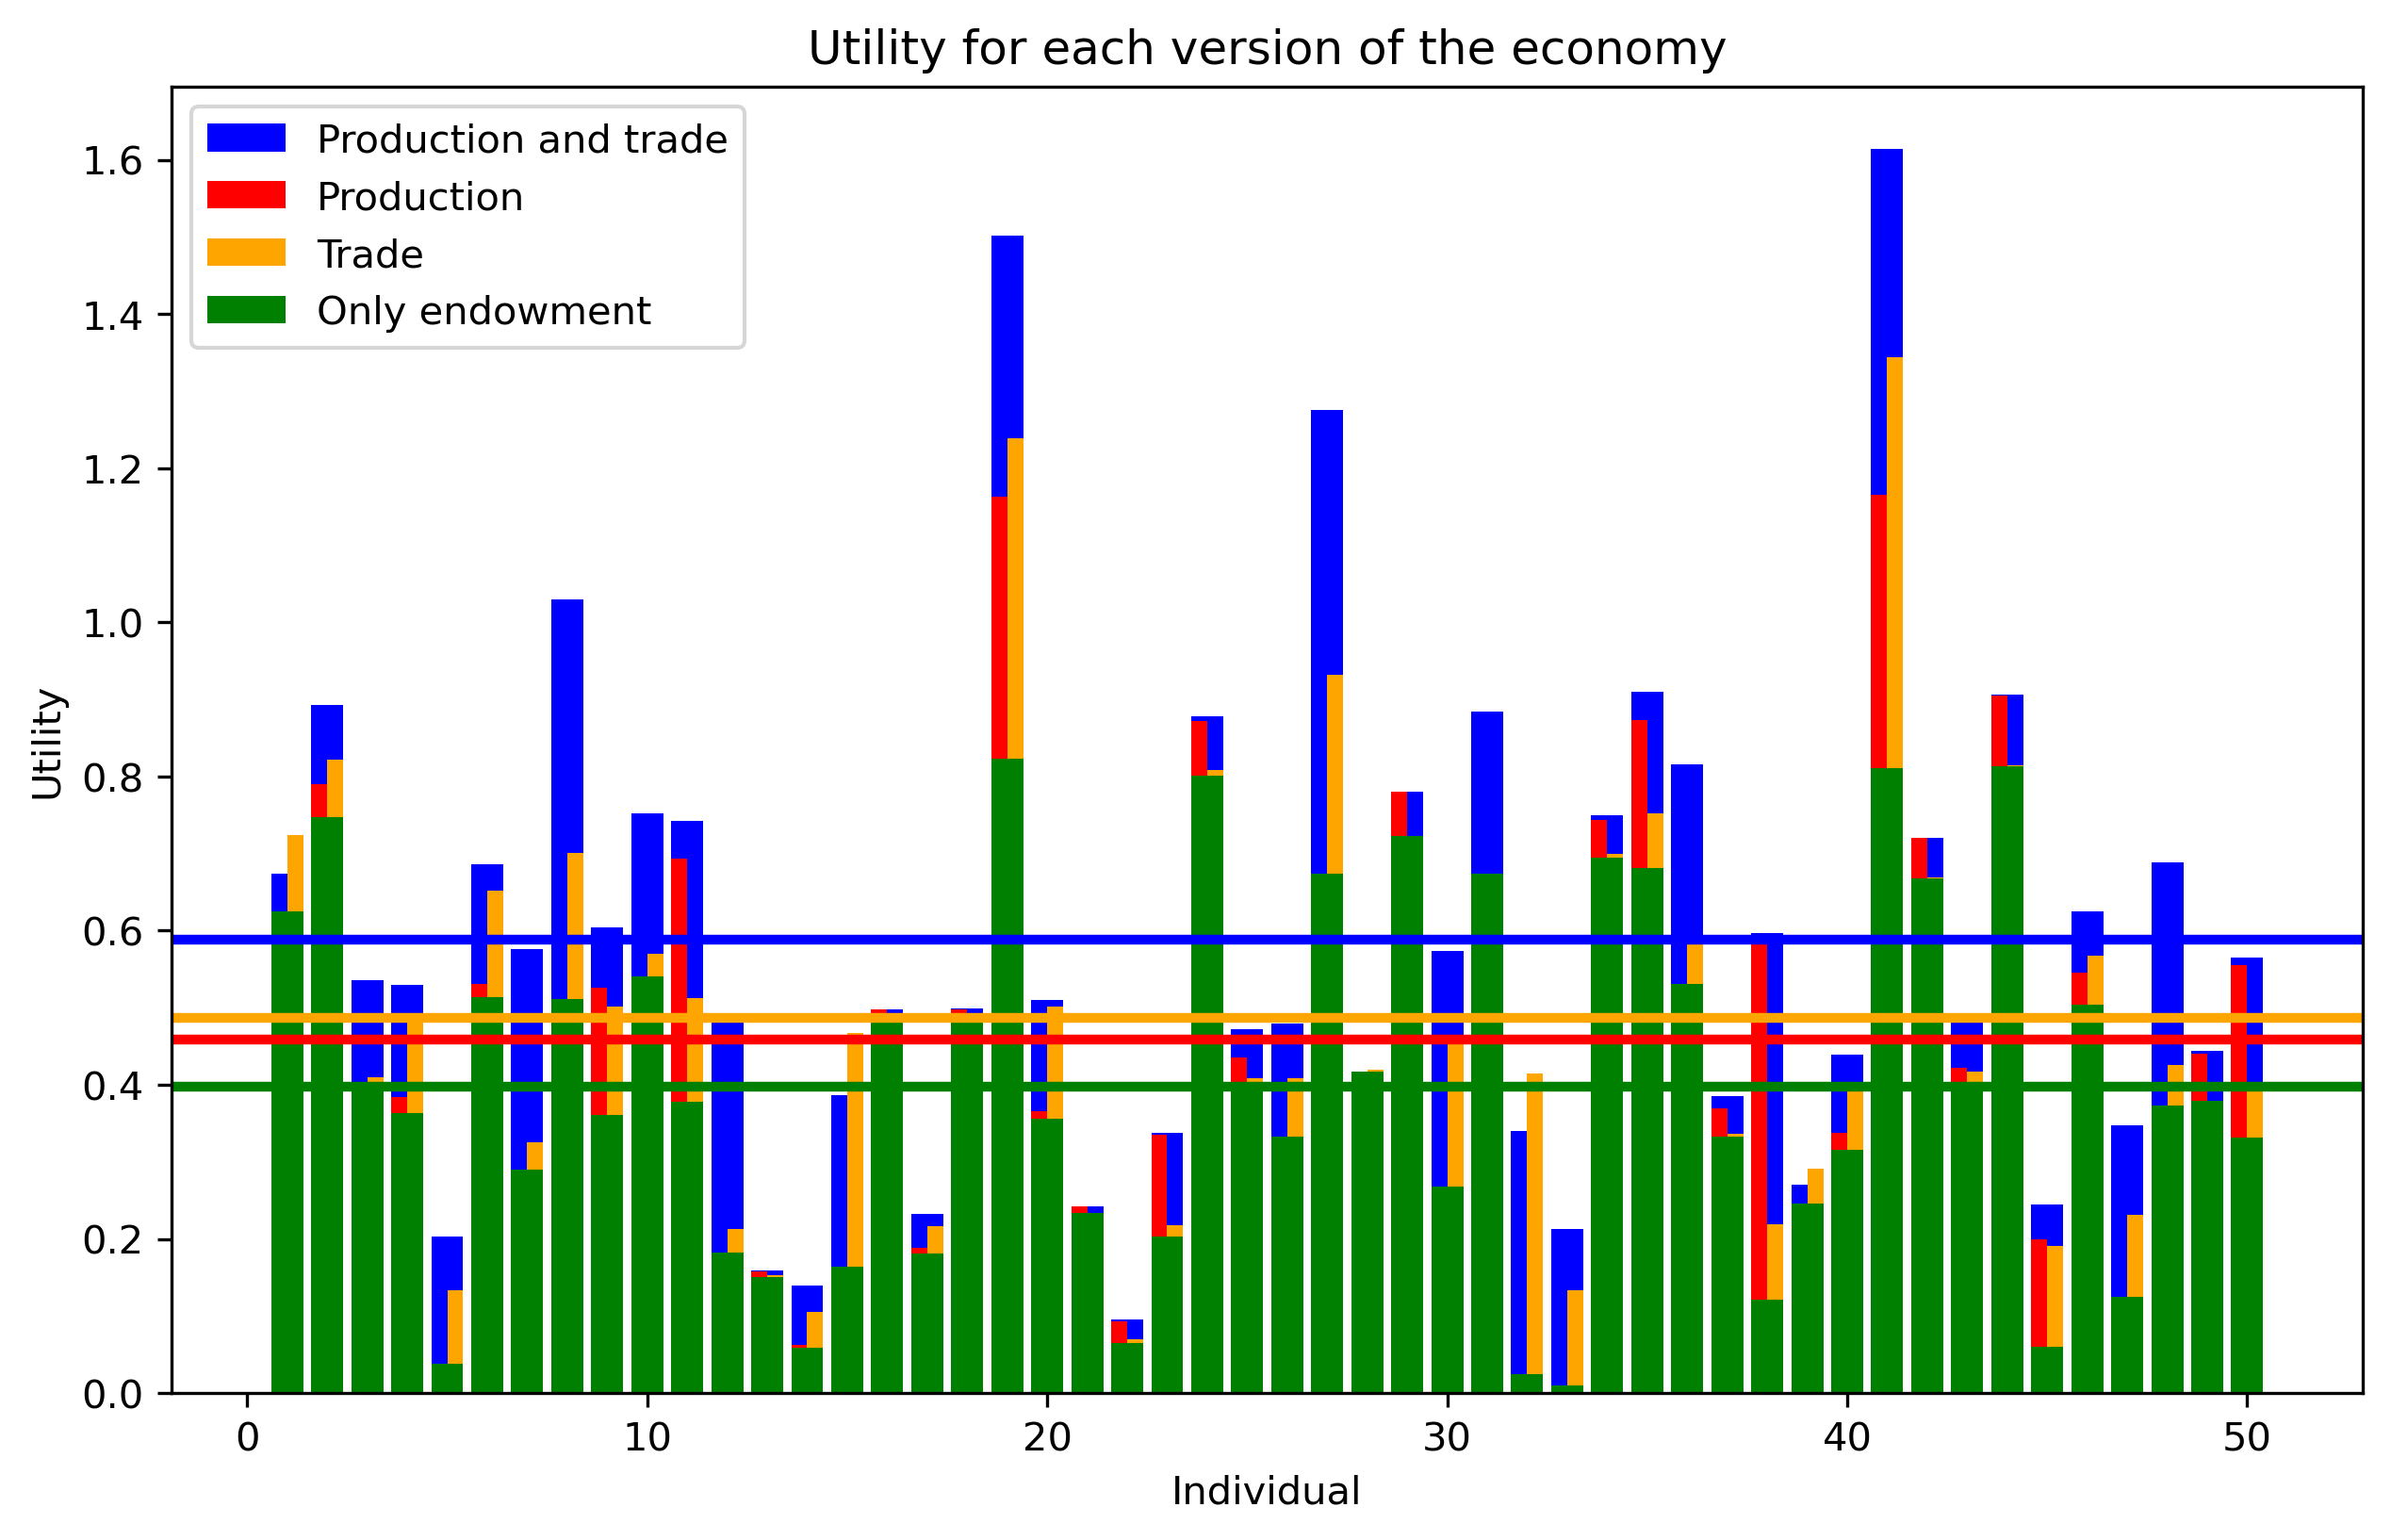

In [14]:
avg_u_initial = np.mean(u_initial)
avg_u_robinson = np.mean(u_robinson)
avg_u_trade = np.mean(u_trade)
avg_u_all   = np.mean(u_all)

r = np.arange(N) + 1
r1 = r - 0.2
r2 = r + 0.2
barWidth = .8
halfbar = .4

plt.figure(figsize=(10, 6), dpi=300) 

plt.bar(r, u_all, color='b', width=barWidth, label='Production and trade')
plt.bar(r1, u_robinson, color='r', width=halfbar, label='Production')
plt.bar(r2, u_trade, color='orange', width=halfbar, label='Trade')
plt.bar(r, u_initial, color='g', width=barWidth, label='Only endowment')

linewidth = 2.5
plt.axhline(y=avg_u_trade,   color='orange', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_robinson, color='r', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_all, color='b', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_initial, color='g', linestyle='-', linewidth=linewidth)

plt.title("Utility for each version of the economy")
plt.ylabel("Utility")
plt.xlabel("Individual")
plt.legend(loc="best")

plt.show()

# Conclusion

In this project we've looked at expansions to the Robinson Crusoe economy. Since there's no general solution to a Robinson Crusoe economy, even with just Robinson Crusoe himself (as far as we know), this is an obvious candidate for numerical optimization. We've expanded the model to include more individuals and to allow trade, and we also look at situations without production.

In line with economic theory, we find that separately allowing for either trade or production results in Pareto improvements due to an expansion of each individual's consumption possibility frontier. Furthermore, expanding from only production to production and trade is also a Pareto improvement. Expanding from trade to production and trade is, however, not a Pareto improvement (as can be seen on the graph above). This is actually not that surprising: An individual with a high endowment of good 2 and a high preference for good 1 can take advantage of a low relative price on good 1 in the trade economy, since good 2 cannot be produced. Once we introduce production, the relative price of good 1 goes up (since the price of good 2 goes down), leaving the high-endowment-of-good-1 individual worse off.